![CSE480: Machine Vision - Major Task](https://i.postimg.cc/tg55zQM7/Screenshot-2025-12-03-051145.png)


# 👥 **Team Members - Team 6** - [![GitHub Repo](https://img.shields.io/badge/GitHub-Repository-blue?logo=github)](https://github.com/Mohamed-Montasser/CSE480-Action-Emotion-Recognition)


| ID      | Name                      |
| ------- | ------------------------- |
| 2100543 | Mohamed Montasser         |
| 2100660 | Fatma Samy Ahmed          |
| 2101231 | Moaz Gamal Alsayed        |
| 2100961 | Mohamed Islam Salah Aldin |
| 2100820 | Zeyad Samer Lotfy         |

# **Objective** 

**In this project, students will design and implement a deep learning–based computer vision system that can recognize human actions and facial emotions from a live camera feed in real time.**

**The system will integrate Convolutional Neural Networks (CNNs) for spatial feature extraction and Long Short-Term Memory (LSTM) networks for temporal pattern recognition. This hybrid CNN–LSTM architecture will enable the model to analyze motion sequences and facial expressions over consecutive frames to classify ongoing human behavior and emotion. By completing both milestones, students will build an end-to-end pipeline capable of detecting, classifying, and visualizing human behavior through real-time video analysis.**


# **Milestone 1: Dataset Preparation and Model Development** 

## **1. Data Collection and Preprocessing**
* Select or prepare datasets for each task: 

    *   Action recognition: UCF-101 or custom video dataset with simple actions (walking, standing, waving, sitting).
    *   Emotion recognition: FER-2013 dataset.

* Extract video frames and preprocess them (resizing, normalization, and augmentation). 

* For the action recognition model, prepare short frame sequences (e.g., 10–20 consecutive frames per clip).

### **1. Imports**

In [1]:
import os
import time
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    TimeDistributed,
    LSTM,
    Dense,
    GlobalAveragePooling2D,
    Input
)

2025-12-07 08:17:06.790842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765095426.967439      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765095427.017026      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### **2. Constants and Configurations**

In [2]:
ACTION_ROOT_DIR = "/kaggle/input/ucf101-action-recognition/"
EMOTION_ROOT_DIR = "/kaggle/input/fer2013/"

# we will only use these 5 actions
ACTION_CLASSES = [
    "WalkingWithDog",
    "PushUps",
    "BrushingTeeth",
    "BlowingCandles",
    "Typing"
]

EMOTION_CLASSES = ['angry','disgust','fear','happy','sad','surprise','neutral']

# image sizes and sequence length
ACTION_IMG_H, ACTION_IMG_W = 64, 64
SEQUENCE_LENGTH = 16      # number of frames per clip

EMO_IMG_SIZE = 48         # 48x48 grayscale for emotion

MAX_VIDS_PER_CLASS = 80 
ACTION_BATCH_SIZE = 4
EMOTION_BATCH_SIZE = 64
EPOCHS = 20

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### **Preprocessing Functions:**
it handle preprocessing, frame extraction, and dataset loading for both the Action Recognition and Emotion Recognition models.

They convert raw videos/images into normalized NumPy arrays ready for training.

#### ***1. preprocess_action_frame(frame):***
  
  **Purpose:**
* Converts a single video frame into a consistent format: -> BGR -> RGB
* Resize to model input size
* Normalize pixel values to [0,1]

This ensures all frames are uniform before feeding them into MobileNetV2 + LSTM.

In [3]:
def preprocess_action_frame(frame):
    # input BGR frame, convert to RGB and resize & normalize
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (ACTION_IMG_W, ACTION_IMG_H))
    resized = resized.astype("float32") / 255.0
    return resized

#### ***2. sample_video_to_sequence(video_path, seq_len)***
**Purpose:**
Loads a video -> extracts seq_len frames -> preprocesses each frame.

**Features:**

* Works with any video length

* Pads short videos with last frame

* Uses evenly spaced sampling (captures motion across entire clip)

* Returns an array of shape (seq_len, H, W, 3)

This creates the temporal frame sequence required for the LSTM.

In [4]:
def sample_video_to_sequence(video_path, seq_len=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Could not open:", video_path)
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        print("No frames in:", video_path)
        return None

    if len(frames) < seq_len:
        while len(frames) < seq_len:
            frames.append(frames[-1])
        selected = frames
    else:
        idxs = np.linspace(0, len(frames) - 1, seq_len).astype(int)
        selected = [frames[i] for i in idxs]

    processed = [preprocess_action_frame(f) for f in selected]
    return np.array(processed)   # (seq_len, H, W, 3)

#### ***3. load_action_split(split_name)***
**Purpose:**
Loads all videos for a specified dataset split (train, val, or test).

**What it does:** Searches class folders -> Loads each video -> Extracts a frame sequence -> Converts labels to one-hot vectors

**Returns:**

* X: shape (num_samples, seq_len, H, W, 3)

* y: one-hot encoded labels

This is the main loader for the Action Recognition model.

In [5]:
def load_action_split(split_name="train"):
    """
    split_name: 'train', 'val', or 'test'
    """
    base_dir = os.path.join(ACTION_ROOT_DIR, split_name)
    X_list = []
    y_list = []

    if not os.path.isdir(base_dir):
        print("Split folder not found:", base_dir)
        return None, None

    label2idx = {cls: i for i, cls in enumerate(ACTION_CLASSES)}

    for cls_name in ACTION_CLASSES:
        cls_path = os.path.join(base_dir, cls_name)
        if not os.path.isdir(cls_path):
            print("Warning: class folder missing:", cls_path)
            continue
        files = [f for f in os.listdir(cls_path)
                 if f.lower().endswith((".avi", ".mp4", ".mov"))]

        random.shuffle(files)
        files = files[:MAX_VIDS_PER_CLASS]

        print(f"[{split_name}] loading {cls_name}, num_videos={len(files)}")

        for vid_file in files:
            video_path = os.path.join(cls_path, vid_file)
            seq = sample_video_to_sequence(video_path, SEQUENCE_LENGTH)
            if seq is None:
                continue
            X_list.append(seq)
            y_list.append(label2idx[cls_name])

    if len(X_list) == 0:
        print("No videos loaded for split:", split_name)
        return None, None

    X = np.array(X_list)
    y = np.array(y_list)
    y_cat = to_categorical(y, num_classes=len(ACTION_CLASSES))

    print(f"Loaded action {split_name}:", X.shape, y_cat.shape)
    return X, y_cat

### **Load action data (train/val/test) "pre-splited"**

In [6]:
print("\n=== Loading ACTION dataset ===")
X_train_a, y_train_a = load_action_split("train")
X_val_a, y_val_a     = load_action_split("val")
X_test_a, y_test_a   = load_action_split("test")


=== Loading ACTION dataset ===
[train] loading WalkingWithDog, num_videos=80
[train] loading PushUps, num_videos=76
[train] loading BrushingTeeth, num_videos=80
[train] loading BlowingCandles, num_videos=80
[train] loading Typing, num_videos=80
Loaded action train: (396, 16, 64, 64, 3) (396, 5)
[val] loading WalkingWithDog, num_videos=15
[val] loading PushUps, num_videos=13
[val] loading BrushingTeeth, num_videos=16
[val] loading BlowingCandles, num_videos=14
[val] loading Typing, num_videos=17
Loaded action val: (75, 16, 64, 64, 3) (75, 5)
[test] loading WalkingWithDog, num_videos=16
[test] loading PushUps, num_videos=13
[test] loading BrushingTeeth, num_videos=17
[test] loading BlowingCandles, num_videos=14
[test] loading Typing, num_videos=17
Loaded action test: (77, 16, 64, 64, 3) (77, 5)


## **2. Model Design**

- Action Recognition Model:
  - Use a CNN (e.g., ResNet or MobileNet) for spatial feature extraction.
  - Feed extracted features into an LSTM network, 1-2 layers, to capture temporal dependencies and recognize actions over time.

#### **Model Definitions — Action Recognition (CNN + LSTM)**

**The Action Recognition model uses a hybrid architecture that combines:**


* A pretrained CNN (MobileNetV2) for spatial feature extraction from each video frame.
* An LSTM network to analyze the temporal sequence of extracted features.
* A fully connected classifier to output the final action label.

**Project requirement:** CNN -> LSTM -> Dense classifier for action recognition.

In [7]:
def build_action_cnn_lstm_model():
    base_cnn = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(ACTION_IMG_H, ACTION_IMG_W, 3)
    )

    base_cnn.trainable = False

    inp = Input(shape=(SEQUENCE_LENGTH, ACTION_IMG_H, ACTION_IMG_W, 3))

    x = TimeDistributed(base_cnn)(inp)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    x = LSTM(128, return_sequences=False)(x)
    x = Dense(128, activation="relu")(x)
    out = Dense(len(ACTION_CLASSES), activation="softmax")(x)

    model = Model(inputs=inp, outputs=out)
    return model

## **3. Training and Optimization**

- Train each model using different optimization algorithms and compare their performance:
  - Stochastic Gradient Descent (SGD)
  - Adam
  - Adagrad

- Record training and validation accuracy, training time, and loss evolution for each optimizer.

> train_action_with_optimizers(X_train, y_train, X_val, y_val)
 
To meet the project requirement of comparing different optimization algorithms, the CNN–LSTM action recognition model is trained three separate times using:

- **SGD**
- **Adam**
- **Adagrad**

For each optimizer, the following metrics are recorded:

- Training and validation accuracy  
- Training and validation loss  
- Total training time  
- Best achieved validation accuracy  

This comparison makes it possible to identify the optimizer that provides the best overall performance for the action recognition model.


In [8]:
def train_action_with_optimizers(X_train, y_train, X_val, y_val):
    optimizers_dict = {
        "sgd": optimizers.SGD(learning_rate=0.001, momentum=0.9),
        "adam": optimizers.Adam(learning_rate=0.001),
        "adagrad": optimizers.Adagrad(learning_rate=0.001)
    }

    histories = {}
    best_model = None
    best_val = -1
    best_name = None

    for opt_name, opt in optimizers_dict.items():
        print("\n=========================")
        print("Training ACTION model with:", opt_name)
        print("=========================\n")

        model = build_action_cnn_lstm_model()
        model.compile(
            optimizer=opt,
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        t0 = time.time()
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=4,
            verbose=1
        )
        t1 = time.time()

        histories[opt_name] = {
            "history": hist.history,
            "model": model,
            "time": t1 - t0
        }

        last_val_acc = hist.history["val_accuracy"][-1]
        print("val_acc =", last_val_acc)

        if last_val_acc > best_val:
            best_val = last_val_acc
            best_name = opt_name
            best_model = model

    print("\nBest ACTION optimizer:", best_name, "val_acc:", best_val)
    return best_model, histories



**Train action model with different optimizers**

In [9]:
best_action_model, action_histories = train_action_with_optimizers(
    X_train_a, y_train_a,
    X_val_a, y_val_a
)
print("\nEvaluating best ACTION model on test split:")
test_loss_a, test_acc_a = best_action_model.evaluate(X_test_a, y_test_a, verbose=0)
print("Action test loss:", test_loss_a, " test acc:", test_acc_a)

I0000 00:00:1765095815.927062      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/tmp/ipykernel_47/2521736453.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(



Training ACTION model with: sgd

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1765095873.567228    2301 cuda_dnn.cc:529] Loaded cuDNN version 90300


99/99 ━━━━━━━━━━━━━━━━━━━━ 84s 291ms/step - accuracy: 0.3578 - loss: 1.4595 - val_accuracy: 0.8533 - val_loss: 0.8608
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9246 - loss: 0.6245 - val_accuracy: 0.9200 - val_loss: 0.4576
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9810 - loss: 0.2608 - val_accuracy: 0.9200 - val_loss: 0.2840
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9926 - loss: 0.1262 - val_accuracy: 0.9467 - val_loss: 0.1984
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9926 - loss: 0.0701 - val_accuracy: 0.9600 - val_loss: 0.1564
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9926 - loss: 0.0454 - val_accuracy: 0.9600 - val_loss: 0.1345
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 0.0322 - val_accuracy: 0.9733 - val_loss: 0.1208
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 1.0000 - loss: 0.0242 - val_accuracy: 0.9867 - val_loss: 

#### **Plotting Training Curves for Optimizer Comparison**
This function generates training and validation curves (accuracy and loss) for each optimizer used during model training. By visualizing these curves, we can compare learning behavior across optimizers such as **SGD**, **Adam**, and **Adagrad**, helping us evaluate which optimizer provides the best convergence speed, stability, and final accuracy.

The function loops through all optimizer histories, producing two plots per optimizer:
- **Accuracy vs. Epochs**
- **Loss vs. Epochs**


In [10]:
def plot_history_curves(histories_dict, title_prefix="model"):
    for opt_name, info in histories_dict.items():
        hist = info["history"]

        plt.figure()
        plt.plot(hist["accuracy"], label="train_acc")
        plt.plot(hist["val_accuracy"], label="val_acc")
        plt.title(f"{title_prefix} accuracy - {opt_name}")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.grid(True)
        plt.legend()

        plt.figure()
        plt.plot(hist["loss"], label="train_loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.title(f"{title_prefix} loss - {opt_name}")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.grid(True)
        plt.legend()

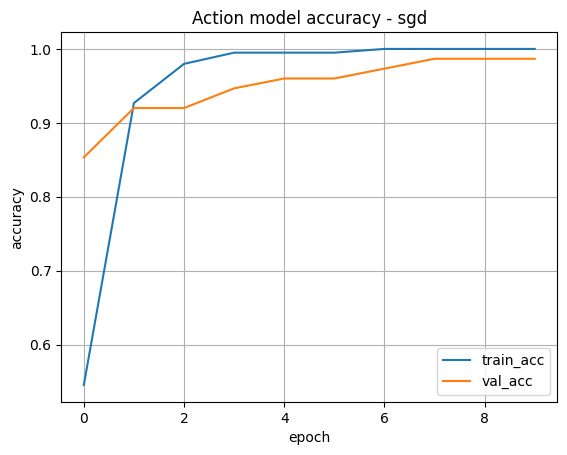

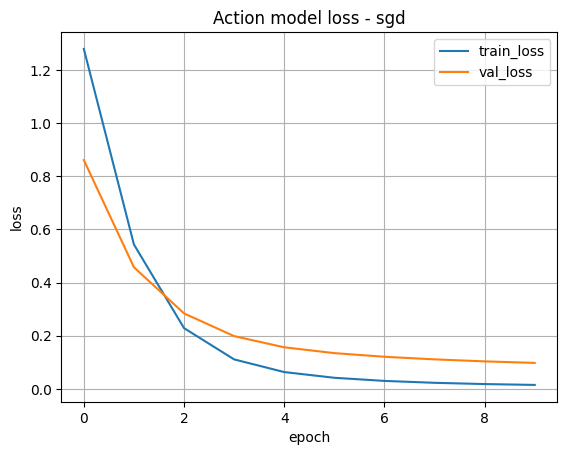

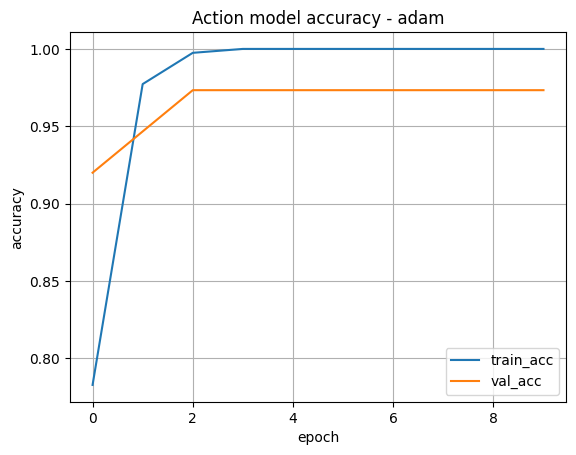

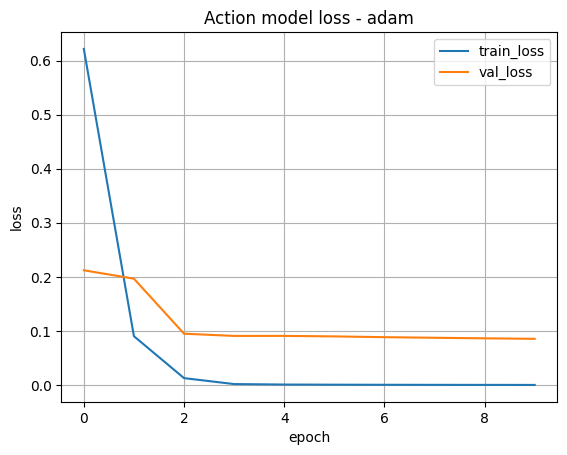

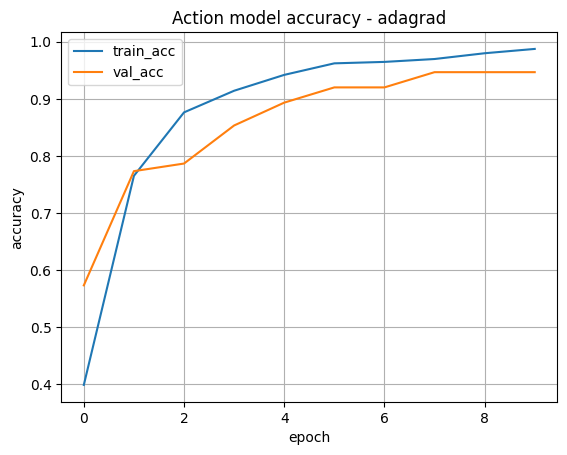

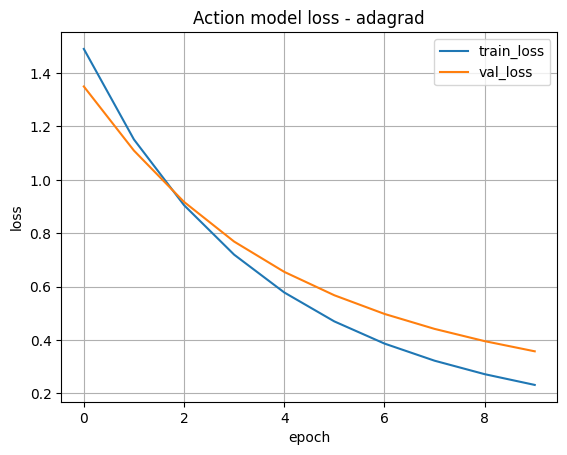

In [11]:
plot_history_curves(action_histories, title_prefix="Action model")

## **4.Model Testing & Visualization**

In [12]:
def test_random_video(model, X_test, y_test, class_names):
    idx = random.randint(0, len(X_test) - 1)

    video = X_test[idx]
    true_label = np.argmax(y_test[idx])

    pred = model.predict(video[np.newaxis, ...])[0]
    pred_label = np.argmax(pred)

    print("=====================================")
    print("Testing Random Video")
    print("True Label     :", class_names[true_label])
    print("Predicted Label:", class_names[pred_label])
    print("=====================================")

    plt.figure(figsize=(8, 8))
    for i in range(SEQUENCE_LENGTH):
        plt.subplot(4, 4, i + 1)
        plt.imshow(video[i])
        plt.axis("off")
    plt.suptitle(
        f"True: {class_names[true_label]}   |   Pred: {class_names[pred_label]}",
        fontsize=14
    )
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Testing Random Video
True Label     : Typing
Predicted Label: Typing


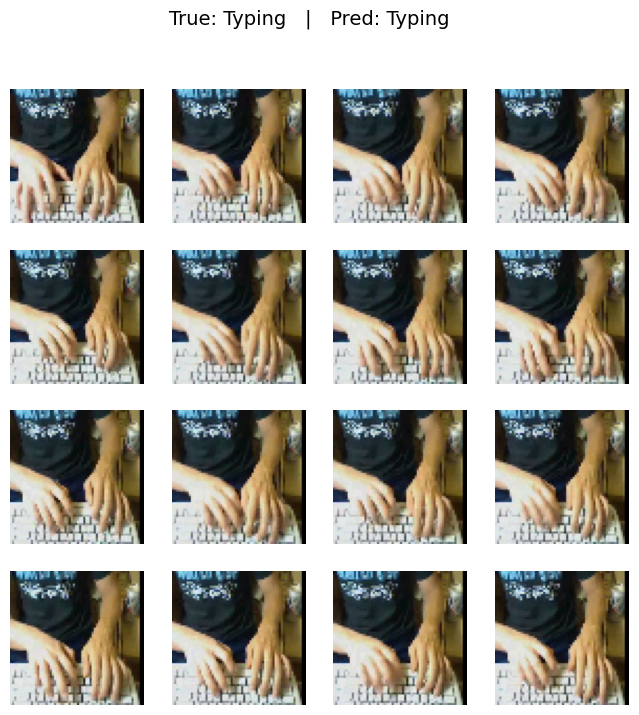

In [13]:
test_random_video(best_action_model, X_test_a, y_test_a, ACTION_CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Testing Random Video
True Label     : WalkingWithDog
Predicted Label: WalkingWithDog


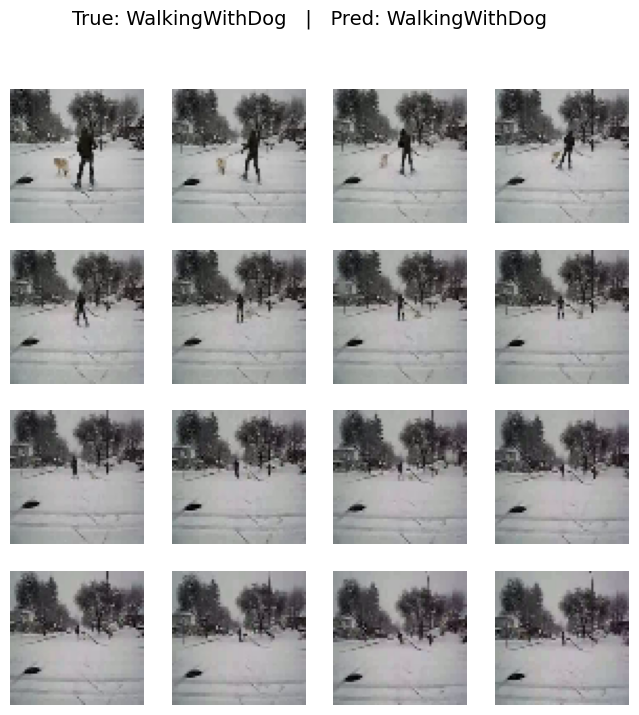

In [14]:
test_random_video(best_action_model, X_test_a, y_test_a, ACTION_CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Testing Random Video
True Label     : BrushingTeeth
Predicted Label: BrushingTeeth


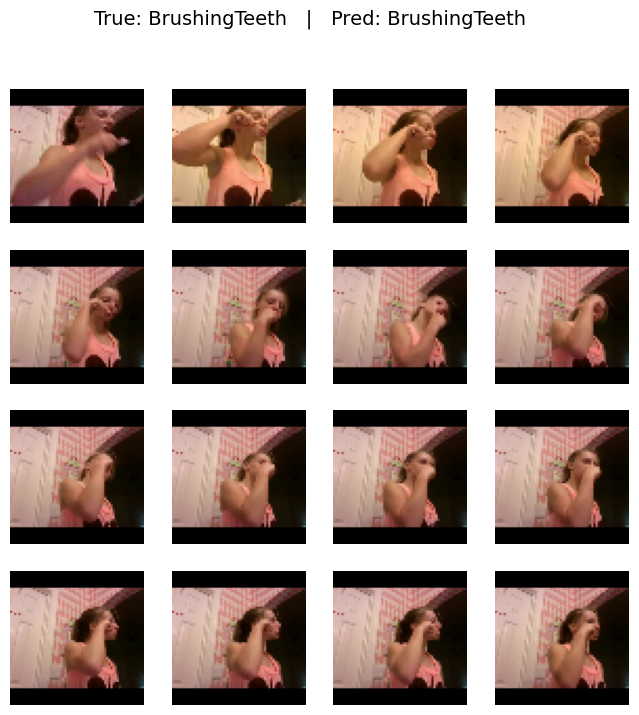

In [17]:
test_random_video(best_action_model, X_test_a, y_test_a, ACTION_CLASSES)

## **5. Save Model**

In [ ]:
best_action_model.save("action_cnn_lstm.h5")

In [ ]:
best_action_model.save("action_cnn_lstm.keras")